Numba is an open source JIT(just in time) compiler, that attempts to translate Python and NumPy code into fast machine code.

In this notebook I will try to highlight how to use Numba, some common pitfalls to avoid and a few tips and tricks to help you along the way.

Most of this is pretty directly implemented from a project I did in INF3331(Now IN3110), and is only made to highlight how to use Numba on a very basic level.

This Jupyter Notebook was made on the University of Oslo's Jupyterhub server, and has only been verified to run there.

<div>
<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Mandel_zoom_00_mandelbrot_set.jpg/322px-Mandel_zoom_00_mandelbrot_set.jpg width="300">
</div>

The Mandelbrot set is a very good example to use when explaining why JIT compilation can be greatly beneficial when we have to do many calculations over and over again. 

The Mandelbrot set is the set obtained from the quadratic recurrence equation
$z_{n+1} = z_{n}^{2} + c$ with $z_{0} = c$, where points $c$ in the complex plane for which the orbit of $z_{n}$ does not tend to infinity are in the set.[<sup>1</sup>](#fn1) 

This means that we make a grid of the complex plane, and then iterate over the points in this grid with this function $n$ times, where $n$ is an integer larger than $2$.

But when do we know when the point will tend towards infinity? This is surprisingly simple, we only need to know if the *modulus* of the current number is greater than $2$. This means that we check that $|z| = \sqrt{Re(z)^{2} + Im(z)^{2}} \leq 2$.

Now, on to the actual code!

First we import some usefull packages and import `jit` from Numba.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from numba import jit

Then we define a simple function to deal with the calculations to be run on the relevant numbers

In [2]:
def mandelbrot_func(z, n_max):
    """
    Iterates over the complex number z up to n_max times.

    Arguments:
        z {complex number} -- Complex number to be iterated
        n_max {int} -- The maximum number of iterations to run

    Outputs:
        i {int} -- How many iterations it took for the number z to "escape"
        0 {int} -- returns 0 if the number z did not "escape" after n_max iterations
    """
    c = z
    for i in range(int(n_max)):
        if np.sqrt((z.real ** 2) + (z.imag ** 2)) >= 2:
            return i
        z = z*z + c
    return 0 

This is a pretty straight forward implementation of the Mandelbrot function, so let's test it!

We could simply do a `timeit` call for a number we know is in the set, but to actually test the function we should run it over a grid several times, so let's make a function to do this!

In [3]:
def mandelbrot_set(func, ranges, dim, n_max):
    """
    Creates a grid of points in the complex plane
    that we can use a mandelbrot function to iterate
    over

    Arguments:
        func {function} -- The function to use for the iteration
        ranges {list} -- list with the minimum and maximum x 
                         and y values to generate a grid from
        dim {list} -- a list containing the width and height
                      of the grid, the amount of points to
                      generate in the x and y directions
        n_max {int} -- the maximum number of iterations to
                       run per point of the grid

    Outputs:
        x {array} -- array with the Real number values of the grid
        y {array} -- array with the Imaginary number values of the grid
        m_xy {array} -- array of the values returned from the iteration function
    """
    x_min, x_max, y_min, y_max = ranges
    w, h = dim
    x = np.linspace(x_min, x_max, int(w))
    y = np.linspace(y_min, y_max, int(h))

    m_xy = np.zeros((int(w), int(h)))
    for i in range(int(w)):
        for j in range(int(h)):
            num = complex(x[i], y[j])
            m_xy[i, j] = func(num, n_max)

    return x, y, m_xy

This function takes in values to generate a grid of complex numbers, and then sends each point to a function that will iterate over that point. So now let's set up our grid!

In [4]:
r = [-2,2,-2,2]
d = [1e2,1e2]
n = 50
n_repeat = 100
n_vals = np.arange(1, n_repeat+1, 1)

We're going to use a pretty small $100$ by $100$ grid, which can iterate a maximum of 50 times, and this function call will be repeated 100 times.

In [5]:
time_py = timeit.repeat(stmt="mandelbrot_set(mandelbrot_func,r,d,n)",
                        setup="from __main__ import mandelbrot_set, mandelbrot_func, r, d, n",
                        number=1,repeat=n_repeat)

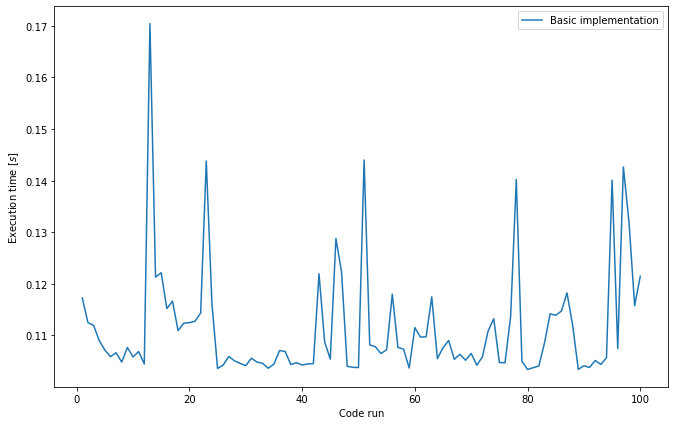

Lowest time py: 0.103 [s]
Highest time py: 0.170 [s]


In [6]:
plt.figure(1, figsize=(11,7))
plt.plot(n_vals, time_py, label = "Basic implementation")
plt.xlabel("Code run")
plt.ylabel(r"Execution time $[s]$")
plt.legend(loc = 1)
plt.show()

lowest_py = np.min(time_py)
highest_py = np.max(time_py)

print(f"Lowest time py: {lowest_py:.3f} [s]")
print(f"Highest time py: {highest_py:.3f} [s]")

We can see that this function has a pretty low runtime, but if we increased the size of our grid to a $1000$ by $1000$ grid, the runtime would be significantly longer!  

It does have some spikes in runtime, this can be caused by any number of things, such as other processes having their calculations done.  

But this simple "Pythonic" implementation can be vastly improved!

We can get rid of the square root calculation from `np.sqrt()`, because we can reformulate our earlier condition $|z| = \sqrt{Re(z)^{2} + Im(z)^{2}} \leq 2$ to $|z| = (Re(z)^{2} + Im(z)^{2}) \leq 4$.  

This means that at every iteration of the loop, we save a function call of `np.sqrt()`.

In [7]:
def mandelbrot_func_improved(z, n_max):
    c = z
    for i in range(int(n_max)):
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
        z = z*z + c
    return 0 

In [8]:
time_py_imp = timeit.repeat(stmt="mandelbrot_set(mandelbrot_func_improved,r,d,n)",
                            setup="from __main__ import mandelbrot_set, mandelbrot_func_improved, r, d, n",
                            number=1,repeat=n_repeat)

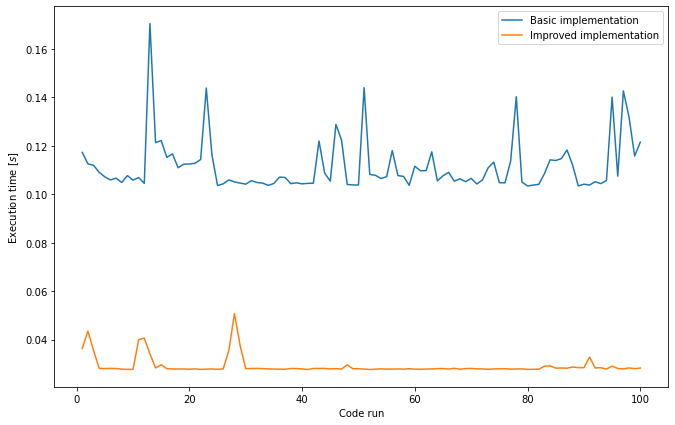

Lowest time py: 0.103 [s]
Highest time py: 0.170 [s] 

Lowest time py_imp: 0.028 [s]
Highest time py_imp: 0.051 [s]


In [9]:
plt.figure(2, figsize=(11,7))
plt.plot(n_vals, time_py, label = "Basic implementation")
plt.plot(n_vals, time_py_imp, label = "Improved implementation")
plt.xlabel("Code run")
plt.ylabel(r"Execution time $[s]$")
plt.legend(loc = 1)
plt.show()

lowest_py_imp = np.min(time_py_imp)
highest_py_imp = np.max(time_py_imp)

print(f"Lowest time py: {lowest_py:.3f} [s]")
print(f"Highest time py: {highest_py:.3f} [s]", "\n")
print(f"Lowest time py_imp: {lowest_py_imp:.3f} [s]")
print(f"Highest time py_imp: {highest_py_imp:.3f} [s]")

We managed to lower the runtime significantly by just dropping some unnecessary calculations. 

We still see some minor spikes, but significantly fewer than before.

Can you think of any calculations we're doing in the AST2000 course where a similar approach can be taken?

Look at one of your calculation loops, and see if there are any calculations being done within them, that can be moved outside.

Now, it's finally time to try JIT, with the `@jit` decorator. We always put the decorator right above the function definition like so:

```
@jit
def func():
    do funkystuff
```

There are a number of keyword-only arguments that we can pass to `@jit` as compilation options[<sup>2</sup>](#fn2).
    
- `nopython` 
- `cache`
- `nogil`
- `parallel`

The most important ones are `nopython` and `cache`.

Numba has two compilation modes, `nopython` mode and `object` mode, which I like to think of as *forced machine code* mode and *improve what you can* mode. 

Code compiled in `object` mode will often run at similar speeds to pure Python code, unless it manages to extract the loops in the code and compile them in `nopython` mode. The `object` mode uses the Python C API to improve code.

However, when we compile code in `nopython` mode we are much more likely to see significant speedups. This forces the compiler to not use the Python C API, but it requires that the native types of all values in the function can be inferred.

This means that the type of Python data passed to, and handled by the function, has to be data that Numba can handle, if Numba can't handle the data handed to it, it throws an error in `nopython` mode.

Numba can handle most `numpy` datatypes, and most basic data types, so if we think about what calculations we want to speed up, we can save a lot of time.  

The `cache` keyword argument is pretty simple, it means that the successfully compiled version of our JIT'ed function will be saved, and can be retrieved instead of recompiled, if we have to rerun the code. (For some reason Jupyter does not let me do it here, but it should work in regular Python code.)

The `parallel` keyword argument tries to automatically parallelize your code, which can lead to even greater speed gains, but is harder to implement. Must be used in conjunction with `nopython` mode. See Numba documentation if interested.

The `nogil` keyword argument releases Python's global interpreter lock(GIL) for the relevant code.(From what I understand, see the Numba documentation for more info)

All of these keyword arguments are passed on the form

```
@jit(kwarg = True/False)
def func():
    do funkystuf
```

Numpy also prefers to receive data with the data type specified, it can normally handle the type inference by itself, but we can give Numba a hand, to make our own lives easier.

In [10]:
def mandelbrot_set_jit(func, ranges, dim, n_max):
    x_min, x_max, y_min, y_max = ranges
    w, h = dim
    x = np.linspace(x_min, x_max, int(w), dtype = np.float64)
    y = np.linspace(y_min, y_max, int(h), dtype = np.float64)

    m_xy = np.zeros((int(w), int(h)), dtype = np.float64)
    for i in range(int(w)):
        for j in range(int(h)):
            num = complex(x[i], y[j])
            m_xy[i, j] = func(num, n_max)

    return x, y, m_xy

Now we're going to just add the `@jit(nopython = True)` decorator to the first function we made, and see how it goes.

In [11]:
@jit(nopython = True)
def mandelbrot_func_jit(z, n_max):
    c = z
    for i in range(int(n_max)):
        if np.sqrt((z.real ** 2) + (z.imag ** 2)) >= 2:
            return i
        z = z*z + c
    return 0 

In [12]:
time_jit = timeit.repeat(stmt="mandelbrot_set_jit(mandelbrot_func_jit,r,d,n)",
                         setup="from __main__ import mandelbrot_set_jit, mandelbrot_func_jit, r, d, n",
                         number=1,repeat=n_repeat)

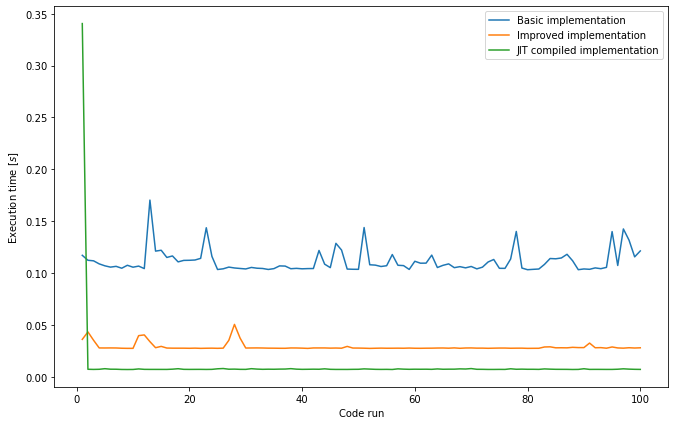

Lowest time py: 0.103 [s]
Highest time py: 0.170 [s] 

Lowest time py_imp: 0.028 [s]
Highest time py_imp: 0.051 [s] 

Lowest time jit: 0.007 [s]
Highest time jit: 0.340 [s]


In [13]:
plt.figure(3, figsize=(11,7))
plt.plot(n_vals, time_py, label = "Basic implementation")
plt.plot(n_vals, time_py_imp, label = "Improved implementation")
plt.plot(n_vals, time_jit, label = "JIT compiled implementation")
plt.xlabel("Code run")
plt.ylabel(r"Execution time $[s]$")
plt.legend(loc = 1)
plt.show()

lowest_jit = np.min(time_jit)
highest_jit = np.max(time_jit)

print(f"Lowest time py: {lowest_py:.3f} [s]")
print(f"Highest time py: {highest_py:.3f} [s]", "\n")
print(f"Lowest time py_imp: {lowest_py_imp:.3f} [s]")
print(f"Highest time py_imp: {highest_py_imp:.3f} [s]", "\n")
print(f"Lowest time jit: {lowest_jit:.3f} [s]")
print(f"Highest time jit: {highest_jit:.3f} [s]")

Here we can see an even greater speed gain.

The reason that the JIT'ed version of our code has such a high runtime on the first pass, should be that Numba has to compile the function to machine code.

This seems quite promising, but let's try using the `@jit(nopython = True)` decorator on the improved function!

In [14]:
@jit(nopython = True)
def mandelbrot_func_imp_jit(z, n_max):
    c = z
    for i in range(int(n_max)):
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
        z = z*z + c
    return 0 

In [15]:
time_imp_jit = timeit.repeat(stmt="mandelbrot_set_jit(mandelbrot_func_imp_jit,r,d,n)",
                             setup="from __main__ import mandelbrot_set_jit, mandelbrot_func_imp_jit, r, d, n",
                             number=1,repeat=n_repeat)

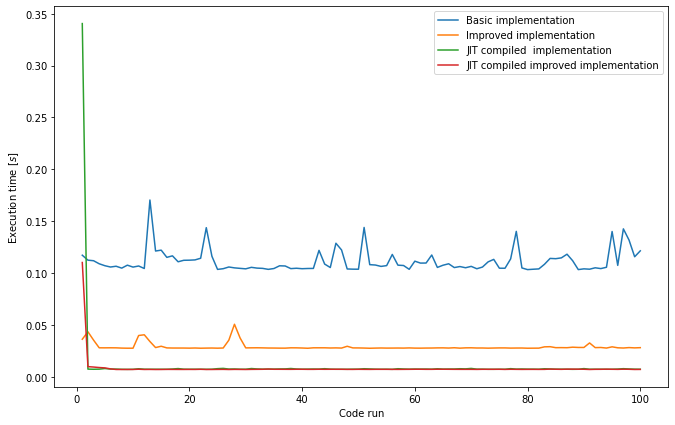

Lowest time py: 0.103 [s]
Highest time py: 0.170 [s] 

Lowest time py_imp: 0.028 [s]
Highest time py_imp: 0.051 [s] 

Lowest time jit: 0.007 [s]
Highest time jit: 0.340 [s] 

Lowest time imp_jit: 0.007 [s]
Highest time imp_jit: 0.110 [s]


In [16]:
plt.figure(3, figsize=(11,7))
plt.plot(n_vals, time_py, label = "Basic implementation")
plt.plot(n_vals, time_py_imp, label = "Improved implementation")
plt.plot(n_vals, time_jit, label = "JIT compiled  implementation")
plt.plot(n_vals, time_imp_jit, label = "JIT compiled improved implementation")
plt.xlabel("Code run")
plt.ylabel(r"Execution time $[s]$")
plt.legend(loc = 1)
plt.show()

lowest_imp_jit = np.min(time_imp_jit)
highest_imp_jit = np.max(time_imp_jit)

print(f"Lowest time py: {lowest_py:.3f} [s]")
print(f"Highest time py: {highest_py:.3f} [s]", "\n")
print(f"Lowest time py_imp: {lowest_py_imp:.3f} [s]")
print(f"Highest time py_imp: {highest_py_imp:.3f} [s]", "\n")
print(f"Lowest time jit: {lowest_jit:.3f} [s]")
print(f"Highest time jit: {highest_jit:.3f} [s]", "\n")
print(f"Lowest time imp_jit: {lowest_imp_jit:.3f} [s]")
print(f"Highest time imp_jit: {highest_imp_jit:.3f} [s]")

We can see that the JIT compilation time was significantly lower, but their general runtimes seem similar. 

Let's have a closer look.

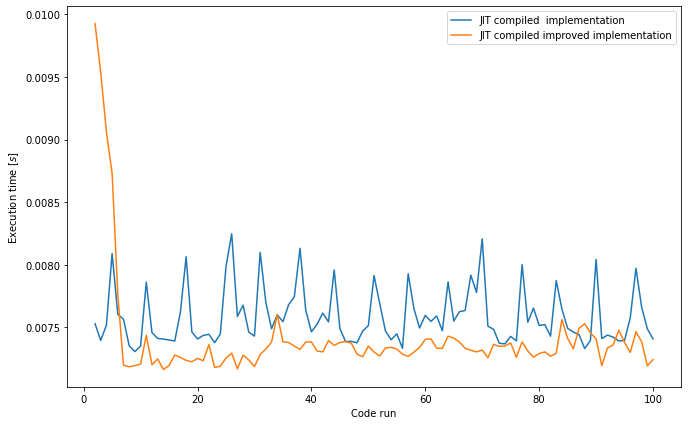

In [17]:
# Omitting the first point, where the function is compiled
plt.figure(4, figsize=(11,7))
plt.plot(n_vals[1:], time_jit[1:], label = "JIT compiled  implementation")
plt.plot(n_vals[1:], time_imp_jit[1:], label = "JIT compiled improved implementation")
plt.xlabel("Code run")
plt.ylabel(r"Execution time $[s]$")
plt.legend(loc = 1)
plt.show()

Their runtimes are again very similar, but both have spiky behaviour at times. 

If you're running this Jupyter notebook yourself, try rerunning the cells and see if the behaviour stays consistent.

In this case the runtimes are so similar, that the improved implementation that saves us a few calculations per loop, seem unneccesary. But I would argue that doing as few calculations as possible, whilst still getting the data you need, is the better aproach.

Let's try a $1000$ by $1000$ point grid with our JIT'ed functions to see how it performs.

In [18]:
d = [1e3,1e3]
n_repeat = 20
n_vals = np.arange(1, n_repeat+1, 1)

In [19]:
time_jit = timeit.repeat(stmt="mandelbrot_set_jit(mandelbrot_func_jit,r,d,n)",
                         setup="from __main__ import mandelbrot_set_jit, mandelbrot_func_jit, r, d, n",
                         number=1,repeat=n_repeat)


In [20]:
time_imp_jit = timeit.repeat(stmt="mandelbrot_set_jit(mandelbrot_func_imp_jit,r,d,n)",
                             setup="from __main__ import mandelbrot_set_jit, mandelbrot_func_imp_jit, r, d, n",
                             number=1,repeat=n_repeat)

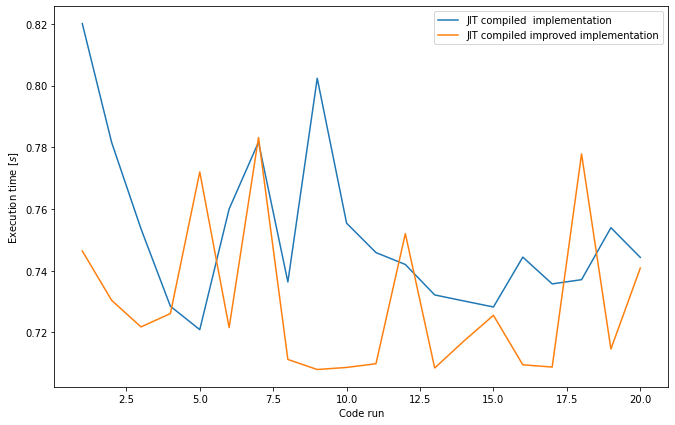

Lowest time jit: 0.721 [s]
Highest time jit: 0.820 [s]
Lowest time imp_jit: 0.708 [s]
Highest time imp_jit: 0.783 [s]


In [21]:
plt.figure(5, figsize=(11,7))
plt.plot(n_vals, time_jit, label = "JIT compiled  implementation")
plt.plot(n_vals, time_imp_jit, label = "JIT compiled improved implementation")
plt.xlabel("Code run")
plt.ylabel(r"Execution time $[s]$")
plt.legend(loc = 1)
plt.show()

lowest_jit = np.min(time_jit)
highest_jit = np.max(time_jit)
lowest_imp_jit = np.min(time_imp_jit)
highest_imp_jit = np.max(time_imp_jit)

print(f"Lowest time jit: {lowest_jit:.3f} [s]")
print(f"Highest time jit: {highest_jit:.3f} [s]")
print(f"Lowest time imp_jit: {lowest_imp_jit:.3f} [s]")
print(f"Highest time imp_jit: {highest_imp_jit:.3f} [s]")

Again, the results seem pretty similar. But KISS (Keep it simple stupid) is still a good approach when it comes to computing.

So let's try making some images with these functions!

In [22]:
def mandelbrot_image(func, ranges, dim, n_max, img_spec):
    """
    Uses the mandelbrot_set function to generate a 
    set and then makes an image of it.
    """
    a, b, c = mandelbrot_set(func, ranges, dim, n_max)
    width, height, cmap = img_spec
    fig2 = plt.figure(1,figsize=(width,height))
    ax2 = fig2.add_subplot(1,1,1,label="2")
    ax2.imshow(c.T,cmap=cmap)

In [23]:
img = [5,5, "inferno"]
d_2 = [1e3, 1e3]

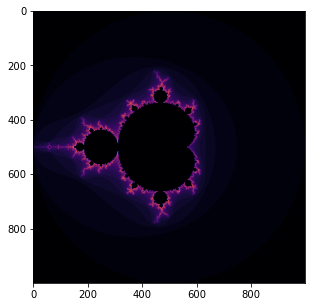

In [24]:
mandelbrot_image(mandelbrot_func,r , d_2, n, img)

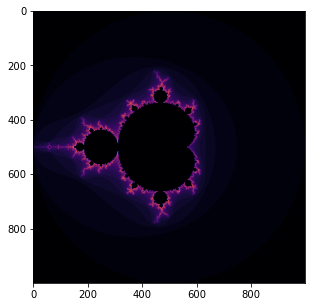

In [25]:
mandelbrot_image(mandelbrot_func_improved,r , d_2, n, img)

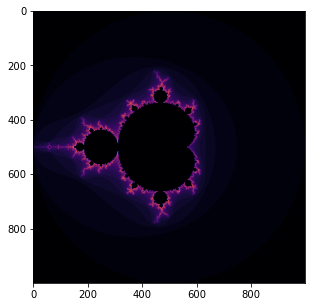

In [26]:
mandelbrot_image(mandelbrot_func_jit,r , d_2, n, img)

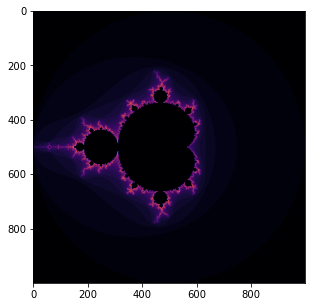

In [27]:
mandelbrot_image(mandelbrot_func_imp_jit,r , d_2, n, img)

We all know that arrays are very powerful when it comes to handling data, and here I'd like to quickly present a little trick that can let you easily manipulate arrays with True/False statements.

Let's say we want to make an array of random integers between 0 and 10:

In [28]:
random_ints = np.random.randint(low = 0, high = 20, size = 10)
print(random_ints)

[ 6 11 11  5  5 17  3  1 12  4]


But oh no! We've made a mistake and made an array of random integers between 0 and 20.

For some reason we can't redo the command, and we also want to keep the initial numbers that are between 0 and 10.

We can get a Boolean array using the `np.greater()` command.

In [29]:
ints_above_10 = np.greater(random_ints, 10)
print(ints_above_10)

[False  True  True False False  True False False  True False]


This is all well and good, but how can we actually use it?

Do we remember how Booleans are stored? As 1's and 0's!, this means we can use these arrays to manipulate other arrays!

So let's just force it to be printed as integers.

In [30]:
print(ints_above_10 * 1)

[0 1 1 0 0 1 0 0 1 0]


Now we want to use this to cancel out the numbers greater than 10, so we use the `np.logical_not()` command to get the inverse of the `ints_above_10` Boolean array, and then multiply that original `random_ints` array with this.

In [31]:
random_ints_half_fixed = random_ints * np.logical_not(ints_above_10)
print(random_ints_half_fixed)

[6 0 0 5 5 0 3 1 0 4]


Now we just make some more random numbers inbetween the actual ranges we want. 

In [32]:
random_ints_replacement = np.random.randint(low = 0, high = 10, size = 10)
print(random_ints_replacement)

[2 8 2 2 5 0 0 7 4 8]


So now we want to use the same trick to cancel out the numbers we don't want.

In [33]:
random_ints_replacement_fixed = (random_ints_replacement * ints_above_10)
print(random_ints_replacement_fixed)

[0 8 2 0 0 0 0 0 4 0]


To make it easier to see that it's worked, we multiply `random_ints_half_fixed` by 100.

In [34]:
random_ints_final = (random_ints_half_fixed * 100) + random_ints_replacement_fixed
print(random_ints_final)

[600   8   2 500 500   0 300 100   4 400]


Now we should hopefully see that it's worked.

What we do in this example is kind of silly, but I've personally sped up my code using this principle where appropriate.

You can also use a Boolean array as a `mask` on another array, this will return an array with only the elements that are `True`.

In [35]:
print(random_ints[ints_above_10])

[11 11 17 12]


Mandelbrot set WolframMathWorld: The earlier definition of the set is taken from here.   
<span id="fn1"> https://mathworld.wolfram.com/MandelbrotSet.html</span>


Official Numba documentation can be found here:  
http://numba.pydata.org/  
http://numba.pydata.org/numba-doc/0.12.2/index.html

Compiling Python code with `@jit`  
<span id="fn2">https://numba.readthedocs.io/en/stable/user/jit.html?</span>  

Mandelbrot Set Image  
https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Mandel_zoom_00_mandelbrot_set.jpg/322px-Mandel_zoom_00_mandelbrot_set.jpg  

Presentation on Numba by Stan Seibert of Anaconda  
https://indico.cern.ch/event/709711/contributions/2915722/attachments/1638199/2614603/2018_04_23_Numba_DIANA_v2.pdf